In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.datasets import make_regression

## SOFR Averages and Index Data ##
* As an extension of the Secured Overnight Financing Rate (SOFR), the SOFR Averages are compounded averages of the SOFR over rolling 30-, 90-, and 180-calendar day periods.
* The SOFR Index measures the cumulative impact of compounding the SOFR on a unit of investment over time, with the initial value set to 1.00000000 on April 2, 2018, the first value date of the SOFR.
* The SOFR Index value reflects the effect of compounding the SOFR each business day and allows the calculation of compounded SOFR averages over custom time periods.
* Each business day, the New York Fed publishes the SOFR Averages and SOFR Index on the New York Fed's website, shortly after the SOFR is published at approximately 8:00 a.m. ET.

# Daily SOFR #

In [38]:
# this is our target?
y_SOFRDAILY = pd.read_excel(f"../data/sofrdaily.xlsx")
y_SOFRDAILY = y_SOFRDAILY.dropna(axis="columns")
y_SOFRDAILY.columns = ["date", "type", "rate_sofrdaily", "vol"]
y_SOFRDAILY["date"] = pd.to_datetime(y_SOFRDAILY["date"])
y_SOFRDAILY.set_index("date", inplace=True)
y_SOFRDAILY.drop(columns=["type", "vol"], inplace=True)
y_SOFRDAILY = y_SOFRDAILY.iloc[::-1]
y_SOFRDAILY.plot(grid=True, title="Daily SOFR")

c:\Users\kilohp\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<Axes: title={'center': 'Daily SOFR'}, xlabel='date'>

# 3 Month Compounded SOFR #

In [39]:
# this is our target?
# y_COMP3MSOFR = pd.read_excel(f"../data/sofravg.xlsx")
# y_COMP3MSOFR = y_COMP3MSOFR.dropna(axis="columns")
# y_COMP3MSOFR.columns = ["date", "type", "30d", "90d", "180d", "idx"]
# y_COMP3MSOFR["date"] = pd.to_datetime(y_COMP3MSOFR["date"])
# y_COMP3MSOFR = y_COMP3MSOFR.iloc[::-1]
# y_COMP3MSOFR.set_index("date", inplace=True)
# y_COMP3MSOFR.drop(columns=["type"], inplace=True)
# y_COMP3MSOFR["90d"].plot(grid=True, title="90 day SOFR average")

# 3 Month Term CME SOFR - problematic data, need to fix #

In [40]:
# this is for comparison
x_CME3MSOFR = pd.read_csv(f"../data/CME3MSOFR.csv")
x_CME3MSOFR = x_CME3MSOFR.dropna(axis="columns")
x_CME3MSOFR.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_CME3MSOFR.columns = ["date", "rate_CME3MSOFR"]
x_CME3MSOFR["date"] = pd.to_datetime(x_CME3MSOFR["date"])
# flip it so that first row
x_CME3MSOFR = x_CME3MSOFR.iloc[::-1]
x_CME3MSOFR.reset_index(inplace=True)
x_CME3MSOFR = x_CME3MSOFR.drop(columns=["index"])
x_CME3MSOFR.set_index("date", inplace=True)
print(x_CME3MSOFR.head())
x_CME3MSOFR["rate_CME3MSOFR"].plot(grid=True, title="CME 3 month term SOFR")

            rate_CME3MSOFR
date                      
2019-01-03          2.4328
2019-01-04          2.4296
2019-01-07          2.4276
2019-01-08          2.4298
2019-01-09          2.4390


<Axes: title={'center': 'CME 3 month term SOFR'}, xlabel='date'>

# 3 Month T-Bill rates #

In [41]:
# this is our feature
# USTbill3M
x_USTbill3M = pd.read_csv(f"../data/USTbill3M.csv")
x_USTbill3M = x_USTbill3M.dropna(axis="columns")
x_USTbill3M.columns = ["date", "rate_USTbill3M"]
x_USTbill3M["date"] = pd.to_datetime(x_USTbill3M["date"])
# no need flip, already in correct order
x_USTbill3M.set_index("date", inplace=True)
print(x_USTbill3M.head())
x_USTbill3M.plot(grid=True, title="US T-bill 3month rate")

            rate_USTbill3M
date                      
2018-11-26          2.3775
2018-11-27          2.3771
2018-11-28          2.3704
2018-11-29          2.3616
2018-11-30          2.3654


<Axes: title={'center': 'US T-bill 3month rate'}, xlabel='date'>

# 1 Month T-Bill rates #

In [42]:
# this is our feature
# USTbill1M
x_USTbill1M = pd.read_csv(f"../data/USTbill1M.csv")
x_USTbill1M = x_USTbill1M.dropna(axis="columns")
x_USTbill1M.columns = ["date", "rate_USTbill1M"]
x_USTbill1M["date"] = pd.to_datetime(x_USTbill1M["date"])
# no need flip, already in correct order
x_USTbill1M.set_index("date", inplace=True)
print(x_USTbill1M.head())
x_USTbill1M.plot(grid=True, title="US T-bill 1month rate")

            rate_USTbill1M
date                      
2023-11-22          5.3506
2023-11-21          5.3375
2023-11-20          5.3507
2023-11-17          5.3475
2023-11-16          5.3506


<Axes: title={'center': 'US T-bill 1month rate'}, xlabel='date'>

# 3 Month SOFR Futures #

In [43]:
# this is our feature
# 3MSOFRFuture
x_3MSOFRFuture = pd.read_csv(f"../data/3MSOFRFuture.csv")
x_3MSOFRFuture = x_3MSOFRFuture.dropna(axis="columns")
x_3MSOFRFuture.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_3MSOFRFuture.columns = ["date", "price_3MSOFRFuture"]
x_3MSOFRFuture["date"] = pd.to_datetime(x_3MSOFRFuture["date"])
# flip it so that first row
x_3MSOFRFuture = x_3MSOFRFuture.iloc[::-1]
x_3MSOFRFuture.reset_index(inplace=True)
x_3MSOFRFuture = x_3MSOFRFuture.drop(columns=["index"])
x_3MSOFRFuture.set_index("date", inplace=True)
print(x_3MSOFRFuture.head())
x_3MSOFRFuture["price_3MSOFRFuture"].plot(grid=True, title="3 month SOFR future price")

            price_3MSOFRFuture
date                          
2018-12-14              97.370
2018-12-17              97.405
2018-12-18              97.455
2018-12-19              97.460
2018-12-20              97.470


<Axes: title={'center': '3 month SOFR future price'}, xlabel='date'>

## Broad General Collateral Rate Data ##
The Broad General Collateral Rate (BGCR) is a measure of rates on overnight Treasury general collateral repurchase agreement (repo) transactions. 

General collateral repo transactions are those for which the specific securities provided as collateral are not identified until after other terms of the trade are agreed. 

The BGCR includes all trades in the Tri-Party General Collateral Rate plus GCF Repo transactions.

c:\Users\kilohp\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


            rate_bgcr
date                 
2018-04-02       1.77
2018-04-03       1.81
2018-04-04       1.70
2018-04-05       1.70
2018-04-06       1.70


<Axes: title={'center': 'BGCR - daily'}, xlabel='date'>

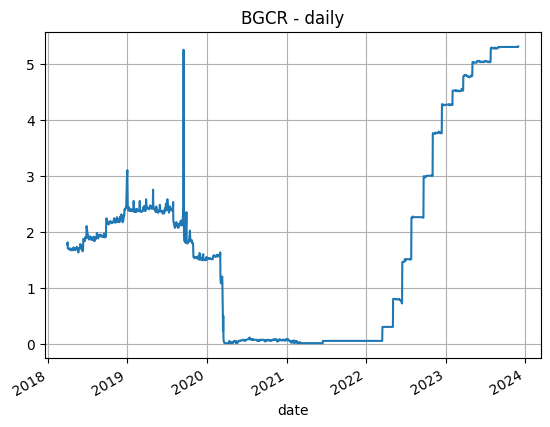

In [44]:
# this is our feature
# bgcr
x_bgcr = pd.read_excel(f"../data/bgcr.xlsx")
x_bgcr = x_bgcr.dropna(axis="columns")
# flip it so that first row
x_bgcr = x_bgcr.iloc[::-1]
x_bgcr.reset_index(inplace=True)
x_bgcr = x_bgcr.drop(columns=["index"])
x_bgcr.columns = ["date", "rate_type", "rate_bgcr", "vol_billion_usd"]
x_bgcr["date"] = pd.to_datetime(x_bgcr["date"])
x_bgcr.drop(columns=["rate_type", "vol_billion_usd"], inplace=True)
x_bgcr.set_index("date", inplace=True)
print(x_bgcr.head())
x_bgcr["rate_bgcr"].plot(grid=True, title="BGCR - daily")

In [45]:
#
x_fomcrate = pd.read_excel(f"../data/fomc_rate.xlsx")
x_fomcrate.columns = ["date", "incr", "decr", "level"]
x_fomcrate[["lo", "hi"]] = x_fomcrate["level"].str.split("-", expand=True)
x_fomcrate["lo"] = pd.to_numeric(x_fomcrate["lo"])
x_fomcrate["hi"] = pd.to_numeric(x_fomcrate["hi"])
x_fomcrate.set_index("date", inplace=True)
x_fomcrate = x_fomcrate.iloc[::-1]
fomcrate_dates = x_fomcrate.index
x_fomcrate

incr  decr      level    lo    hi
date                                         
2018-03-22    25     0  1.50-1.75  1.50  1.75
2018-06-14    25     0  1.75-2.00  1.75  2.00
2018-09-27    25     0  2.00-2.25  2.00  2.25
2018-12-20    25     0  2.25-2.50  2.25  2.50
2019-08-01     0    25  2.00-2.25  2.00  2.25
2019-09-19     0    25  1.75-2.00  1.75  2.00
2019-10-31     0    25  1.50-1.75  1.50  1.75
2020-03-03     0    50  1.00-1.25  1.00  1.25
2020-03-16     0   100     0-0.25  0.00  0.25
2022-03-17    25     0  0.25-0.50  0.25  0.50
2022-05-05    50     0  0.75-1.00  0.75  1.00
2022-06-16    75     0  1.50-1.75  1.50  1.75
2022-07-28    75     0  2.25-2.50  2.25  2.50
2022-09-22    75     0  3.00-3.25  3.00  3.25
2022-11-03    75     0  3.75-4.00  3.75  4.00
2022-12-15    50     0  4.25-4.50  4.25  4.50
2023-02-02    25     0  4.50-4.75  4.50  4.75
2023-03-23    25     0  4.75-5.00  4.75  5.00
2023-05-04    25     0  5.00-5.25  5.00  5.25
2023-07-27    25     0  5.25-5.50  5.25  5.50

In [46]:
fomcrate_dates = [x for x in fomcrate_dates if x > y_SOFRDAILY.iloc[0]._name]
fomcrate_dates

[Timestamp('2018-06-14 00:00:00'),
 Timestamp('2018-09-27 00:00:00'),
 Timestamp('2018-12-20 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-19 00:00:00'),
 Timestamp('2019-10-31 00:00:00'),
 Timestamp('2020-03-03 00:00:00'),
 Timestamp('2020-03-16 00:00:00'),
 Timestamp('2022-03-17 00:00:00'),
 Timestamp('2022-05-05 00:00:00'),
 Timestamp('2022-06-16 00:00:00'),
 Timestamp('2022-07-28 00:00:00'),
 Timestamp('2022-09-22 00:00:00'),
 Timestamp('2022-11-03 00:00:00'),
 Timestamp('2022-12-15 00:00:00'),
 Timestamp('2023-02-02 00:00:00'),
 Timestamp('2023-03-23 00:00:00'),
 Timestamp('2023-05-04 00:00:00'),
 Timestamp('2023-07-27 00:00:00')]

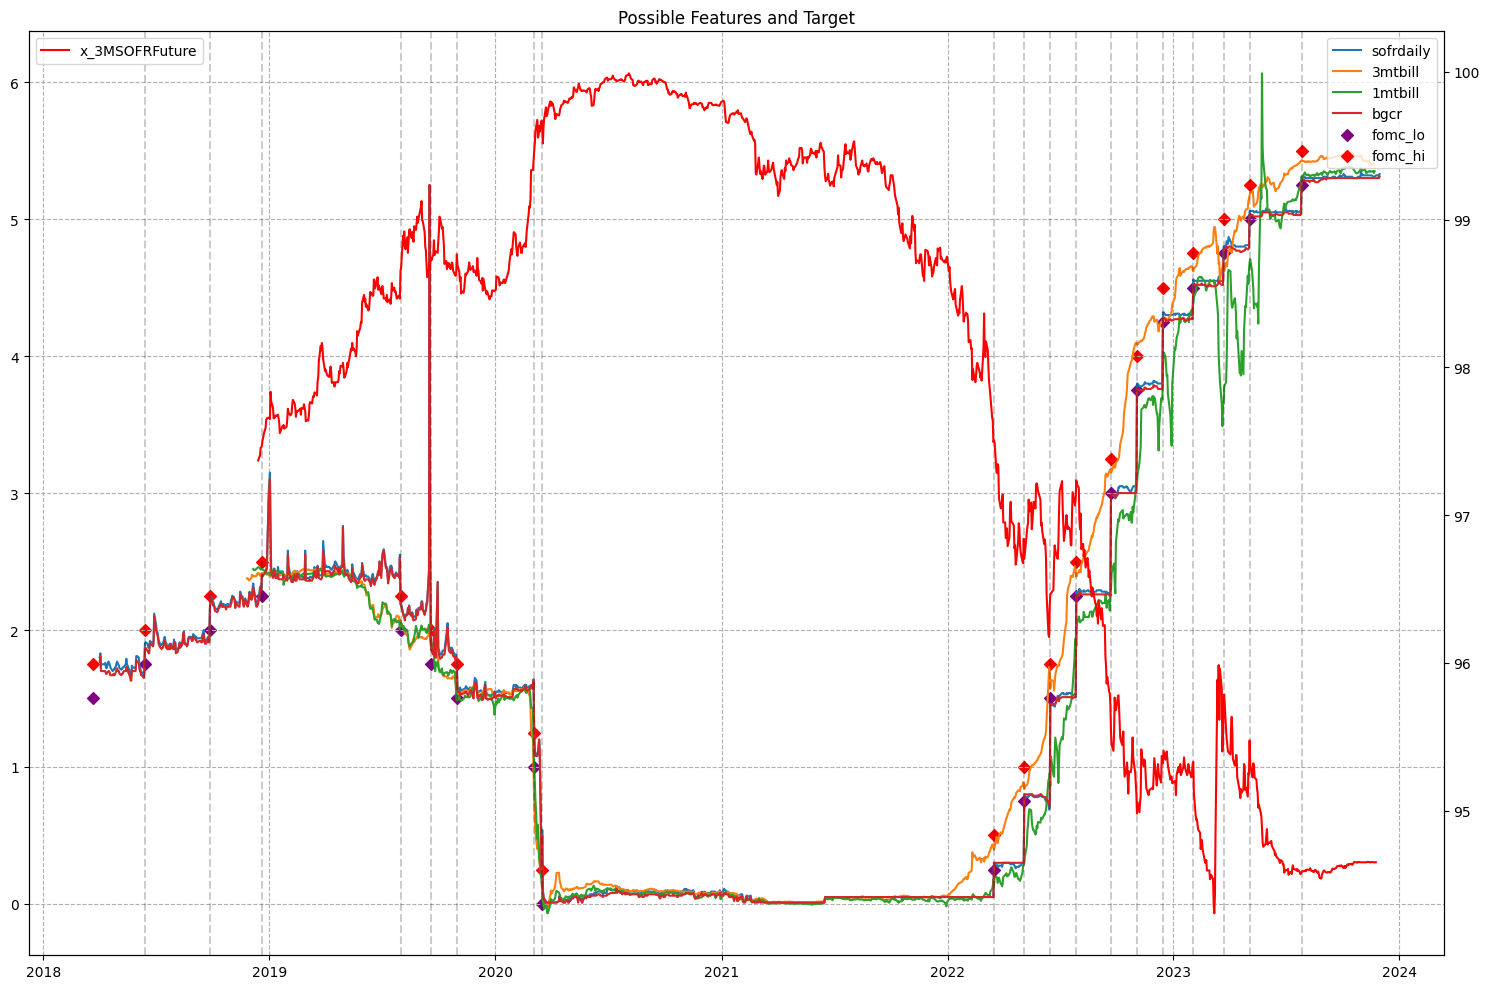

In [47]:
# all together
fig, ax1 = plt.subplots(figsize=(15, 10))
# ax1.plot(x_bgcr["rate_bgcr"], label="bgcr")
# ax1.plot(x_tgcr["rate_tgcr"], label="tgcr")
ax1.plot(y_SOFRDAILY["rate_sofrdaily"], label="sofrdaily")
ax1.plot(x_USTbill3M["rate_USTbill3M"], label="3mtbill")
ax1.plot(x_USTbill1M["rate_USTbill1M"], label="1mtbill")
ax1.plot(x_bgcr["rate_bgcr"], label="bgcr")

ax1.scatter(
    x=x_fomcrate.index, y=x_fomcrate["lo"], label="fomc_lo", marker="D", color="purple"
)
ax1.scatter(
    x=x_fomcrate.index, y=x_fomcrate["hi"], label="fomc_hi", marker="D", color="red"
)

# plt.plot(x_3MSOFRFuture["x_price_3MSOFRFuture"], label="3mfut")
#  ax1.plot(y_COMP3MSOFR["90d"], label="90d")
# THIS IS MISSINGOCTOBER DATA SOMEHOW
# ax1.plot(x_CME3MSOFR["rate_CME3MSOFR"], label="cme3m")
for x in fomcrate_dates:
    ax1.axvline(x=x, linestyle="dashed", color="black", alpha=0.2)
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(x_3MSOFRFuture["price_3MSOFRFuture"], label="x_3MSOFRFuture", color="red")
ax2.legend(loc="upper left")
ax1.legend(loc="upper right")

ax1.grid(linestyle="dashed")
plt.title("Possible Features and Target")
plt.tight_layout()
plt.show()

# Data Concatenate to align time period #

In [48]:
# lets give it a shot ?
df = y_SOFRDAILY.copy()
# df.drop(columns=["30d", "180d", "idx"], inplace=True)
df

rate_sofrdaily
date                      
2018-04-02            1.80
2018-04-03            1.83
2018-04-04            1.74
2018-04-05            1.75
2018-04-06            1.75
...                    ...
2023-11-24            5.32
2023-11-27            5.32
2023-11-28            5.32
2023-11-29            5.31
2023-11-30            5.33

[1417 rows x 1 columns]

In [49]:
to_concat = [x_3MSOFRFuture, x_USTbill3M]
for frames in to_concat:
    df = pd.merge(df, frames, on="date", how="left")
    print(df.isna().sum())
print(df.describe())

rate_sofrdaily          0
price_3MSOFRFuture    181
dtype: int64
rate_sofrdaily          0
price_3MSOFRFuture    181
rate_USTbill3M        169
dtype: int64
       rate_sofrdaily  price_3MSOFRFuture  rate_USTbill3M
count     1417.000000         1236.000000     1248.000000
mean         1.814086           97.823819        1.866083
std          1.745361            1.833774        1.901367
min          0.010000           94.305000       -0.031200
25%          0.070000           96.361250        0.090275
50%          1.730000           98.515000        1.556850
75%          2.430000           99.380000        2.691925
max          5.350000           99.990000        5.491500


In [50]:
rows_with_na = df[df.isna().any(axis=1)]
rows_with_na

rate_sofrdaily  price_3MSOFRFuture  rate_USTbill3M
date                                                          
2018-04-02            1.80                 NaN             NaN
2018-04-03            1.83                 NaN             NaN
2018-04-04            1.74                 NaN             NaN
2018-04-05            1.75                 NaN             NaN
2018-04-06            1.75                 NaN             NaN
...                    ...                 ...             ...
2023-11-24            5.32               94.65             NaN
2023-11-27            5.32                 NaN             NaN
2023-11-28            5.32                 NaN             NaN
2023-11-29            5.31                 NaN             NaN
2023-11-30            5.33                 NaN             NaN

[182 rows x 3 columns]

In [51]:
df.dropna(inplace=True)
df.head(30)

rate_sofrdaily  price_3MSOFRFuture  rate_USTbill3M
date                                                          
2018-12-14            2.21              97.370          2.4184
2018-12-17            2.31              97.405          2.4049
2018-12-18            2.32              97.455          2.3925
2018-12-19            2.30              97.460          2.4096
2018-12-20            2.41              97.470          2.4130
2018-12-21            2.40              97.505          2.4142
2018-12-24            2.41              97.565          2.4135
2018-12-26            2.44              97.590          2.4186
2018-12-27            2.44              97.645          2.4166
2018-12-28            2.46              97.655          2.4058
2018-12-31            3.00              97.660          2.4042
2019-01-02            3.15              97.650          2.3895
2019-01-03            2.70              97.835          2.3919
2019-01-04            2.45              97.770          2.4058
2019-01-07            2.41              97.725          2.4127
2019-01-08            2.42              97.655          2.4243
2019-01-09            2.45              97.665          2.4213
2019-01-10            2.43              97.660          2.4232
2019-01-11            2.41              97.675          2.4222
2019-01-14            2.40              97.670          2.4234
2019-01-15            2.46              97.680          2.4171
2019-01-16            2.43              97.655          2.4060
2019-01-17            2.41              97.625          2.4005
2019-01-18            2.42              97.555          2.4002
2019-01-22            2.41              97.600          2.4034
2019-01-23            2.40              97.595          2.3997
2019-01-24            2.41              97.610          2.3881
2019-01-25            2.40              97.585          2.3964
2019-01-28            2.39              97.595          2.4008
2019-01-29            2.40              97.600          2.4063

In [52]:
# df["price_3MSOFRFuture"] = df["price_3MSOFRFuture"].shift(5)
# df["rate_USTbill3M"] = df["rate_USTbill3M"].shift(5)
# df = df.dropna()

In [53]:
y = df["rate_sofrdaily"].copy()
X = df.drop(columns=["rate_sofrdaily"]).copy()

In [54]:
X.head()

price_3MSOFRFuture  rate_USTbill3M
date                                          
2018-12-14              97.370          2.4184
2018-12-17              97.405          2.4049
2018-12-18              97.455          2.3925
2018-12-19              97.460          2.4096
2018-12-20              97.470          2.4130

In [55]:
y.head()

date
2018-12-14    2.21
2018-12-17    2.31
2018-12-18    2.32
2018-12-19    2.30
2018-12-20    2.41
Name: rate_sofrdaily, dtype: float64

## Mutual Information ##

In [56]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)

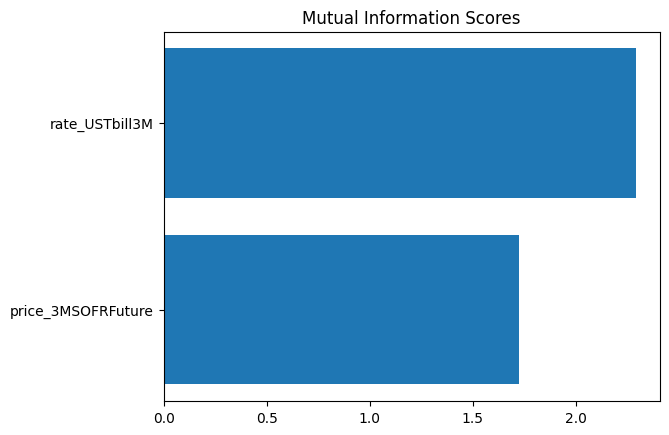

In [57]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100)
plot_mi_scores(mi_scores)

# VIF CHECK #

In [58]:
# Calculate VIF for each predictor variable
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_data


# Display the VIF values
vif_results = calculate_vif(X)
print(vif_results)

             Variable       VIF
0  price_3MSOFRFuture  1.885337
1      rate_USTbill3M  1.885337


iseng doang

In [59]:
my_test_size = 300

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=my_test_size, shuffle=False
)

model = LinearRegression()
model.fit(X_train, y_train)
y_fit = pd.Series(
    model.predict(X_train), index=y_train.index
)  # y from predicting using X_train
y_pred = pd.Series(
    model.predict(X_test), index=y_test.index
)  #  y from predicting using X_test

In [61]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

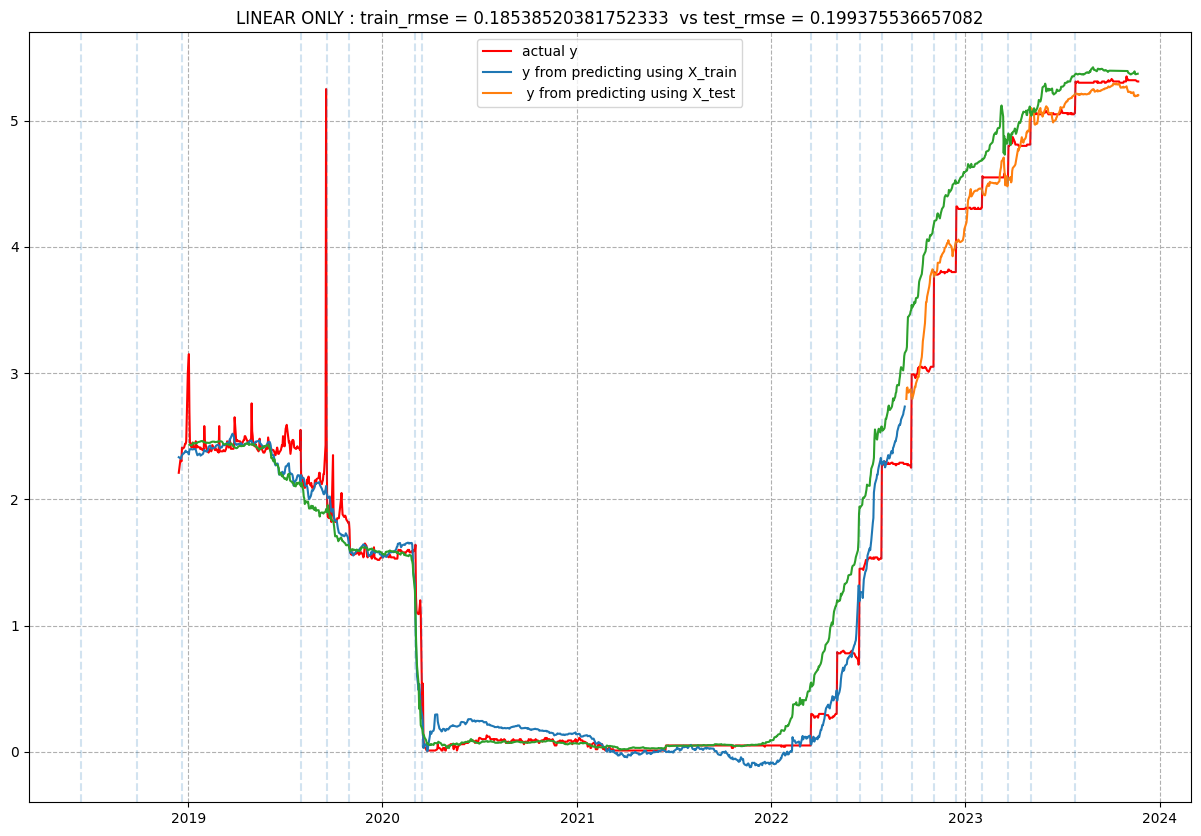

In [62]:
plt.figure(figsize=(15, 10))
plt.plot(y, label="actual y", color="red")
plt.plot(y_fit, label="y from predicting using X_train")
# plt.plot(y_cut, label="y_cut")
plt.plot(y_pred, label=" y from predicting using X_test")
plt.title(f"LINEAR ONLY : train_rmse = {train_rmse}  vs test_rmse = {test_rmse}")
for x in fomcrate_dates:
    plt.axvline(x=x, linestyle="dashed", alpha=0.2)
plt.plot(x_CME3MSOFR["rate_CME3MSOFR"])
plt.grid(linestyle="dashed")
plt.legend()

## xgboost ##

In [63]:
import xgboost as xgb
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=my_test_size, shuffle=False
)

model = LinearRegression()
model.fit(X_train, y_train)
y_fit = pd.Series(
    model.predict(X_train), index=y_train.index
)  # y from predicting using X_train
y_pred = pd.Series(
    model.predict(X_test), index=y_test.index
)  #  y from predicting using X_test

# create target residuals
y_resid = y_train - y_fit

<Axes: xlabel='date'>

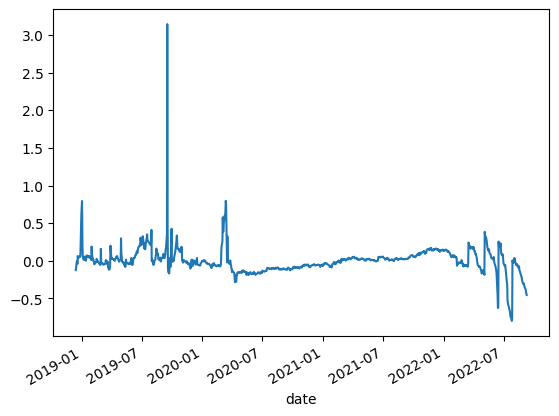

In [64]:
y_resid.plot()

{'whiskers': [<matplotlib.lines.Line2D at 0x1dd8ce1ffd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dd8ce4da10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dd8c6ffb90>],
 'medians': [<matplotlib.lines.Line2D at 0x1dd8ce4eb90>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dd8ce4d050>],
 'means': []}

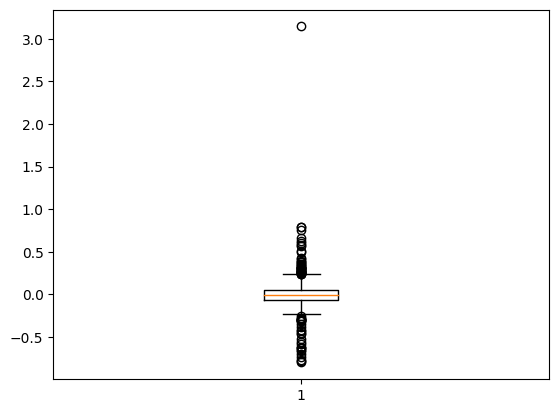

In [65]:
plt.boxplot(y_resid)

In [66]:
y_resid.describe()

count    9.350000e+02
mean    -1.927395e-15
std      1.854844e-01
min     -7.983691e-01
25%     -7.064476e-02
50%     -1.094671e-03
75%      5.279048e-02
max      3.144813e+00
dtype: float64

          y_resid
count  935.000000
mean    -0.002902
std      0.154940
min     -0.798369
25%     -0.070645
50%     -0.001095
75%      0.052790
max      0.797003


<Axes: xlabel='date'>

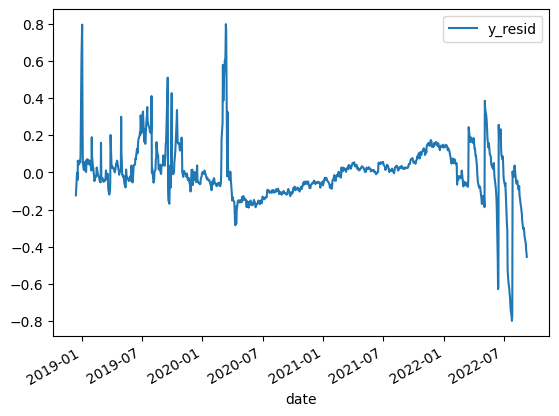

In [67]:
# adjust outliers?
from scipy.interpolate import interp1d

# Sample data (replace this with your actual dataset)
y_resid_no_outlier = pd.DataFrame(y_resid, index=y_train.index)
y_resid_no_outlier.columns = ["y_resid"]
# Identify and Remove Outliers using Z-score
z_scores = (
    y_resid_no_outlier["y_resid"] - y_resid_no_outlier["y_resid"].mean()
) / y_resid_no_outlier["y_resid"].std()
outliers = z_scores.abs() > 5  # Adjust the threshold as needed
y_resid_no_outlier[outliers] = np.nan
y_resid_no_outlier.interpolate(inplace=True)
print(y_resid_no_outlier.describe())
y_resid_no_outlier.plot()

In [68]:
X_train.describe()

price_3MSOFRFuture  rate_USTbill3M
count          935.000000      935.000000
mean            98.733631        0.909932
std              0.996121        0.978797
min             96.175000       -0.031200
25%             98.037500        0.057950
50%             98.830000        0.180500
75%             99.587500        1.901400
max             99.990000        2.963100

In [69]:
# Train XGBoost on the residuals
xgb_reg = xgb.XGBRegressor(n_estimators=10000)
xgb_reg.fit(X_train, y_resid_no_outlier["y_resid"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [70]:
# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb_reg.predict(X_train) + y_fit
y_pred_boosted = xgb_reg.predict(X_test) + y_pred

In [71]:
train_rmse = mean_squared_error(y_train, y_fit_boosted, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_boosted, squared=False)

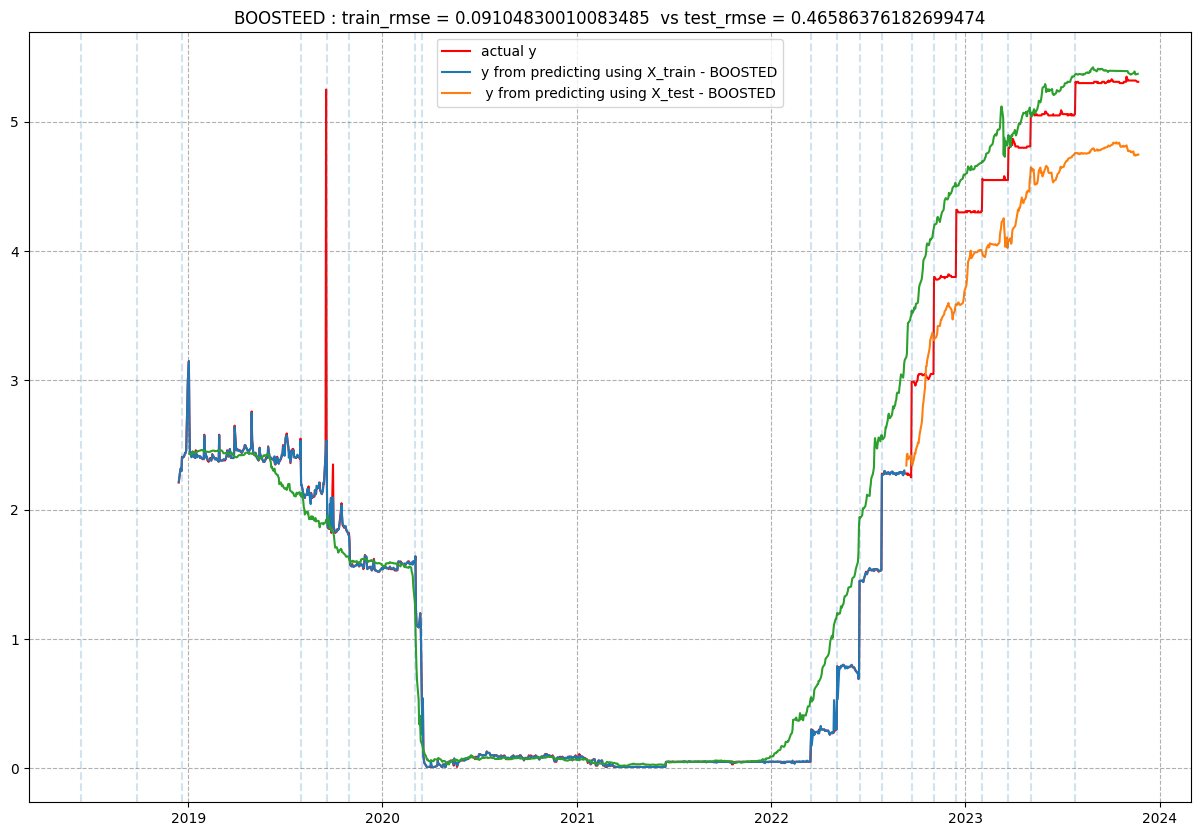

In [72]:
plt.figure(figsize=(15, 10))
plt.plot(y, label="actual y", color="red")
plt.plot(y_fit_boosted, label="y from predicting using X_train - BOOSTED")
# plt.plot(y_cut, label="y_cut")
plt.plot(y_pred_boosted, label=" y from predicting using X_test - BOOSTED")
plt.title(f"BOOSTEED : train_rmse = {train_rmse}  vs test_rmse = {test_rmse}")
plt.plot(x_CME3MSOFR["rate_CME3MSOFR"])
for x in fomcrate_dates:
    plt.axvline(x=x, linestyle="dashed", alpha=0.2)
plt.grid(linestyle="dashed")
plt.legend()